# A Bayesian mixed effects Support Vector Machine for learning and predicting daily alcohol use disorder patterns


This notebook takes daily substance use logs and learns patterns of use. Features include:
* Standard summaries and graphics of drinking data (e.g., 7-day, 30-day frequencies)
* Handles both fixed and random effects in a flexible Bayesian mixed effects SVM (we call it Mixed.SVM)
* Provides classification for the variable of interest (heavy drinking days in this example).  
* Provides effect estimates and 95% credible intervals (unlike standard SVMs).
* Inference can be drawn using the credible intervals (is the variable associated with heavy drinking days?).
* Estimates individual-level risk patterns.

## Dataset
To illustrate the toolkit, we use data from the ABQ DrinQ study, a research study that follows a cohort of heavy drinkers over time.

First we read in the daily log data from a study. This tracks if the individual used alcohol, nicotine, cannabis, or other drugs. The results in this notebook correspond to the results in the manuscript. 

Please see the daily-drinking-notebook-demo for a notebook you can interactively run on simulated data. 

***

In [1]:
rm(list=ls()) # cleans memory

setwd('/home/baurley/Dropbox/analytics') # !!! change path to directory below your Mixed.SVM folder


load('Mixed.SVM/data/processed/drinks.RData') # loads daily log (note that the study data is not provided)

In [2]:
dim(drinks)
head(drinks)

[1] 109580     11

ursi,male,age,Day,SD,AD,HD,MD,NICUSEDAY,THCUSEDAY,OTHERDRUGUSE
87101886,1,37,1,3.84,1,0,1,1,0,0
87101886,1,37,2,3.84,1,0,1,1,1,0
87101886,1,37,3,3.84,1,0,1,1,0,0
87101886,1,37,4,3.84,1,0,1,1,1,0
87101886,1,37,5,3.84,1,0,1,1,1,0
87101886,1,37,6,6.72,1,1,0,1,0,0


Above we loaded the daily drinking and drug use data:


| Variable | Description | Coding |
| :--------| :--------- |   ------|
| ursi | Individual ID |        |
| male | Male | 1=male;2=female | 
| age | Age in years | 
| Day | Day | |
| SD | Standard drinks consumed | 
| AD | Did drinking take place? | 1=yes;0=no |
| HD | Did heavy drinking take place? | 1=yes;0=no |
| MD | Did moderate drinking take place? | 1=yes;0=no |
| NICUSEDAY | Any nicotine use (cigarettes, e-cigs, smokekess, etc) | 1=yes;0=no |
| THCUSEDAY | Any use of THC | 1=yes;0=no |
| OTHERDRUGUSE | Any use of any other drugs | 1=yes;0=no |



We want to learn the alcohol drinking patterns in this data. In other words, we want to fit a model of heavy drinking (`HD`) considering demographics (`age`, `male`) and additional variables that may change over time and influence risk of heavy drinking, including other substances (nicotine, cannabis, and other drugs; `NICUSEDAY`, `THCUSEDAY`, and `OTHERDRUGUSE`, respectively). 


***


## Model

The Mixed.SVM is described in detail in the Methodology section of the manuscript.

The analysis requires several R libraries. We'll go ahead and install and load these now.

In [3]:
packages <- c("statmod", "mvtnorm",
             "Matrix", "splines","xtable","IRdisplay","repr","plotly",
              "extrafont","ggplot2","gridExtra","grid","table1")

## Now load or install and load 
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

# set up for plotting figures
options(bitmapType="cairo") #linux

# Note: if the figures are not displaying correctly, try to install the r-cairo package in Anaconda

#options(bitmapType="quartz") # mac

set.seed(1) #sets a seed for random number generators used by the algorithm



Loading required package: statmod
Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: splines
Loading required package: xtable
Loading required package: IRdisplay

Attaching package: ‘IRdisplay’

The following object is masked from ‘package:xtable’:

    display

Loading required package: repr
Loading required package: plotly
Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: extrafont
Registering fonts with R
Loading required package: gridExtra
Loading required package: grid
Loading required package: table1

Attaching package: ‘table1’

The following objects are masked from ‘package:xtable’:

    label, label<-

The following objects are masked from ‘package:base’:

    units, units<-



Next we source the algorithm code as well as tools to help summarize the results.

In [4]:
source('Mixed.SVM/src/R/mixed-svm.R')

The arguments of Mixed.SVM are the following

| Argument | Description | Setting |
| -------- | ----------- | --------- | 
| Y | Response vector encoded 0 and 1 | `HD` |
| X | Design matrix corresponding to Y | `male`, `age`, `NICUSEDAY`, `THCUSEDAY`, `OTHERDRUGUSE` |
| T | Vector of times at which the observations in Y were taken | `Day` |
| U | Vector which indentifies the user IDs for the observations in `Y`, `X`, and `T` | `ursi` |
| Tmax | Maximum time to be included in the analysis | 720 |
| knot.seq | Interior knot set for subject specific trajectories | 0.5 | 
| Iter | Number of MCMC iterations | 100000 |
| burn.in | Number of MCMC iterations to discard | 50000

We set these parameters for modeling:

In [6]:
Y <- as.vector(drinks$HD) # outcome
X <- as.matrix(drinks[,c("male","age","NICUSEDAY","THCUSEDAY","OTHERDRUGUSE")]) # covariates
T <- as.vector(drinks$Day) # times
U <- as.vector(drinks$ursi) # individual id
Tmax <- 720
knot.seq <- c(0.5)
Iter <- 100000
burn.in <- 50000

Next we call the Mixed.SVM algorithm or load in a previous run. 

In [8]:
# Runs the algorithm and saves the results. Uncomment to execute.
#MCMC.res <- Mixed.SVM(Y, X, T, U, Tmax, knot.seq, Iter) 
#save(MCMC.res,file='Mixed.SVM/reports/results.RData')

# Here we pull up previously saved results
load(file='Mixed.SVM/reports/results.RData')

***

## Results


### Daily drinking summaries

First we summarize daily drinking for the input dataset:

| Variable | Description |
| -------- | ----------- |
| pdd | Percent drinking days |
| phdd | Percent heavy drinking days |
| ddd | Average standard drinks per drinking day |
| dpd | Average standard drinks per day |
| totaldays | total days |
| totaldrinkdays | total number of drinking days |
| totalheavydays | total number of heavy drinking days | 
| phwd | percent heavy drinking days while drinking | 
| mxd | maximum standard drinks|

At the baseline assessment in this study, the participants are interviewed and a detailed log of daily drinking is created for the previous 3 months (90 days). So we start summarizing drinking on day 90. Day 181 corresponds to three month after baseline, day 364 for the nine month visit, and day 637 for the eighteen month visit. For these four visits, we'll summarize these variables for the previous month (30 days).

These are easily adjustable for your study, see `time` and `visitdays` below. The `log.summaries` function generates individual level summaries for the the variables described above. `includevisitday` indicates if the visit day should be included in the summary or not.

In [9]:
iid <- unique(drinks$ursi) # individual id's found in the dataset
time <- 30 # summarize for one month before the visit
visitdays <- c(90,181,364,637) # visit days: baseline, 3-months, 9-months, 18-months

# summarize previous week at baseline, 3-,9-,and 12-months
base <- log.summaries(iid, timeframe=time,visitday=visitdays[1],includevisitday=FALSE)
mo3 <- log.summaries(iid, timeframe=time,visitday=visitdays[2],includevisitday=FALSE)
mo9 <- log.summaries(iid, timeframe=time,visitday=visitdays[3],includevisitday=FALSE)
mo18 <- log.summaries(iid, timeframe=time,visitday=visitdays[4],includevisitday=FALSE)


We summarize drinking over the participants in the study by computing the mean, standard deviation, median, minimum, maximum, and number of missing observations for one month of drinking logs at baseline, 3 month, 9 months, and 18 months.

In [10]:
base$visit <- "Baseline"
mo3$visit <- "3 Months"
mo9$visit <- "9 Months"
mo18$visit <- "18 Months"

allmo <- rbind(base,mo3,mo9,mo18)
allmo$visit <- factor(allmo$visit,levels=c("Baseline","3 Months", "9 Months", "18 Months"))


In [11]:
label(allmo$pdd) <- "<b>Percent drinking days"
label(allmo$phdd) <- "<b>Percent heavy drinking days"
label(allmo$ddd) <- "<b>Average standard drinks per drinking day"
label(allmo$dpd) <- "<b>Average standard drinks per day"
label(allmo$totaldays) <- "<b>Total days"
label(allmo$totaldrinks) <- "<b>Total drinks"
label(allmo$totaldrinkdays) <- "<b>Total number of drinking days"
label(allmo$totalheavydays) <- "<b>Total number of heavy drinking days" 
label(allmo$phwd) <- "<b>Percent heavy drinking days while drinking"
label(allmo$mxd) <- "<b>Maximum standard drinks"

display_html(table1(~pdd + phdd + ddd + dpd + totaldrinks + totaldays + totaldrinkdays + 
                    totalheavydays + phwd + mxd | visit, data=allmo,caption="30-Day Drinking Summaries", overall=NULL))

,Baseline(N=190),3 Months(N=190),9 Months(N=190),18 Months(N=190)
Percent drinking days,,,,
Mean (SD),0.507 (0.280),0.456 (0.305),0.468 (0.322),0.432 (0.329)
"Median [Min, Max]","0.467 [0, 1.00]","0.400 [0, 1.00]","0.400 [0, 1.00]","0.367 [0, 1.00]"
Missing,0 (0%),26 (13.7%),35 (18.4%),45 (23.7%)
Percent heavy drinking days,,,,
Mean (SD),0.289 (0.274),0.239 (0.273),0.275 (0.319),0.272 (0.314)
"Median [Min, Max]","0.200 [0, 1.00]","0.133 [0, 1.00]","0.133 [0, 1.00]","0.167 [0, 1.00]"
Missing,0 (0%),26 (13.7%),35 (18.4%),45 (23.7%)
Average standard drinks per drinking day,,,,
Mean (SD),5.91 (3.76),5.64 (3.37),5.42 (3.47),5.67 (4.00)


Let's take a look at the individual trends in heavy drinking over the duration of the study. 

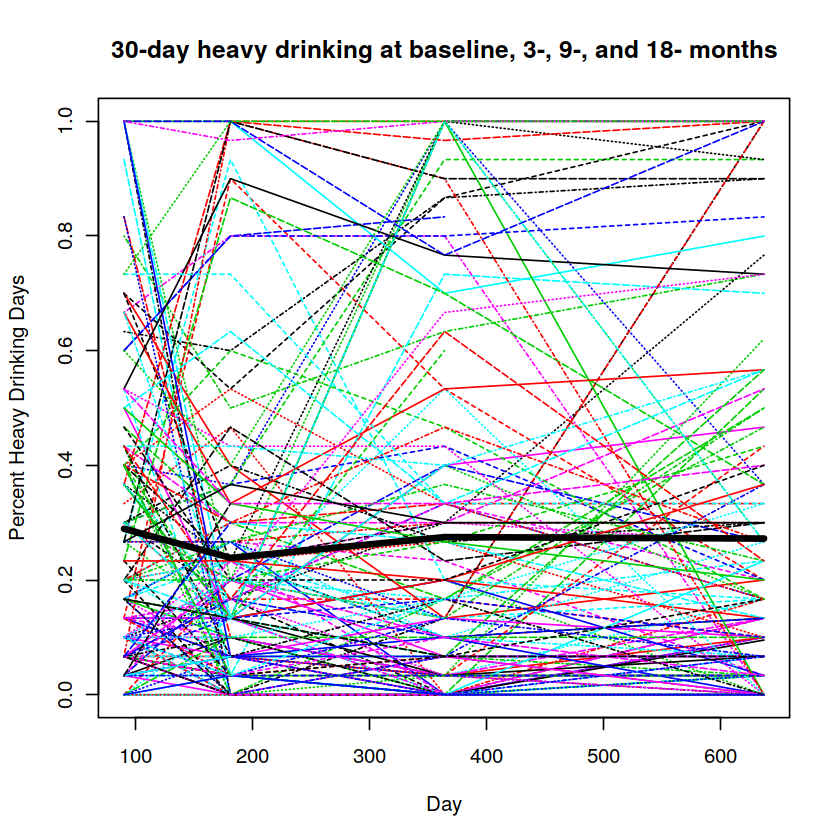

In [12]:
# put together the summaries of heavy drinking days in the past month at the four assessments
trend <- cbind(base=base$phdd,mo3=mo3$phdd,mo9=mo9$phdd,mo18=mo18$phdd)
h <- t(trend) # transpose for plotting
ave <- rowMeans(h,na.rm=TRUE) # average values across individuals
matplot(visitdays, h, type='l', xlab='Day', ylab='Percent Heavy Drinking Days',main="30-day heavy drinking at baseline, 3-, 9-, and 18- months") # plot the trend over the study
matlines(visitdays,ave,lwd=4,col="black") # plot the average

The individuals in this study on average drank heavily 25-30% of the past 30 days before each assessment. However, each individual has their own drinking pattern that typical summaries would not capture. 

### Mixed-SVM results
The `Mixed.SVM` algorithm takes some time to run 100K iterations. We have loaded the results of a previous run so we can look at the results.

### Classification Rate

In [13]:
mean(1-(MCMC.res$Misclassified[burn.in:Iter]/2)/nrow(drinks))

[1] 0.8353741

The classification rate is the number of times the model correctly predicts a heavy drinking day out of 109,580 observations (190 individuals) in the ABQ DrinQ data.The model classifies 84% of heavy drinking days correctly. 

### Parameter Summary

In [14]:
# Regression parameter summary
names <- c("male","age","NICUSEDAY","THCUSEDAY","OTHERDRUGUSE")

summary <- Reg.summary(MCMC.res,burn.in,names)
summary 

Variable,Point Est.,Lower:CI95,Upper:CI95,
male,-0.2541,-0.2915,-0.2157,significant
age,-0.0263,-0.0275,-0.0253,significant
NICUSEDAY,1.6692,1.5961,1.7321,significant
THCUSEDAY,0.0466,0.0288,0.0651,significant
OTHERDRUGUSE,1.1866,0.9993,1.3538,significant


Overall among heavy drinkers, we find that age (younger), gender (female), and using nicotine, cannabis, and other drugs are associated with increase risk of heavy drinking episodes. A variable is statistically significant when the 95% credible intervals do not contain zero. 

### Report of subject specific heavy drinking risk

Next we look at the estimated risk trajectories for each study participant. Since there are many trajectories and the user may want to quickly examine the entire cohort, we include some code to layout the graphs 6 per page. For space, we only display the graphs for the first 18 participants.

Each graph is labeled with the de-identified participant id. The risk of heavy drinking is charted by days that individual is followed in the study up to `Tmax`. Values above zero indicate increased risk of heavy drinking and values below zero indicate decreased risk of heavy drinking. The influence of using or discontinuing use of other substances (e.g, tobacco) can be seen by jumps in risk.

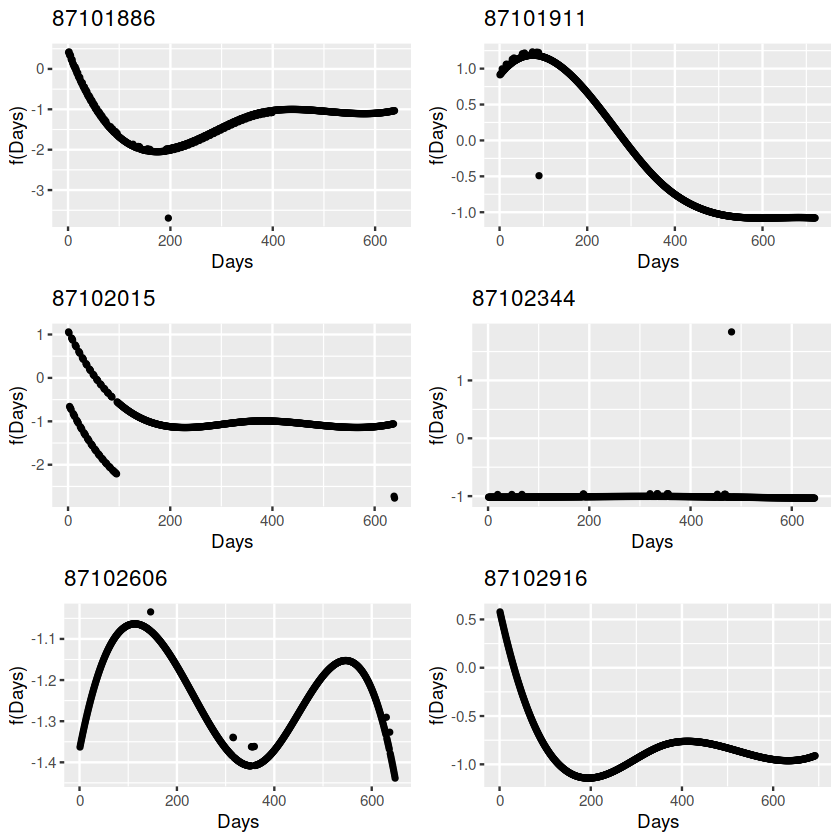

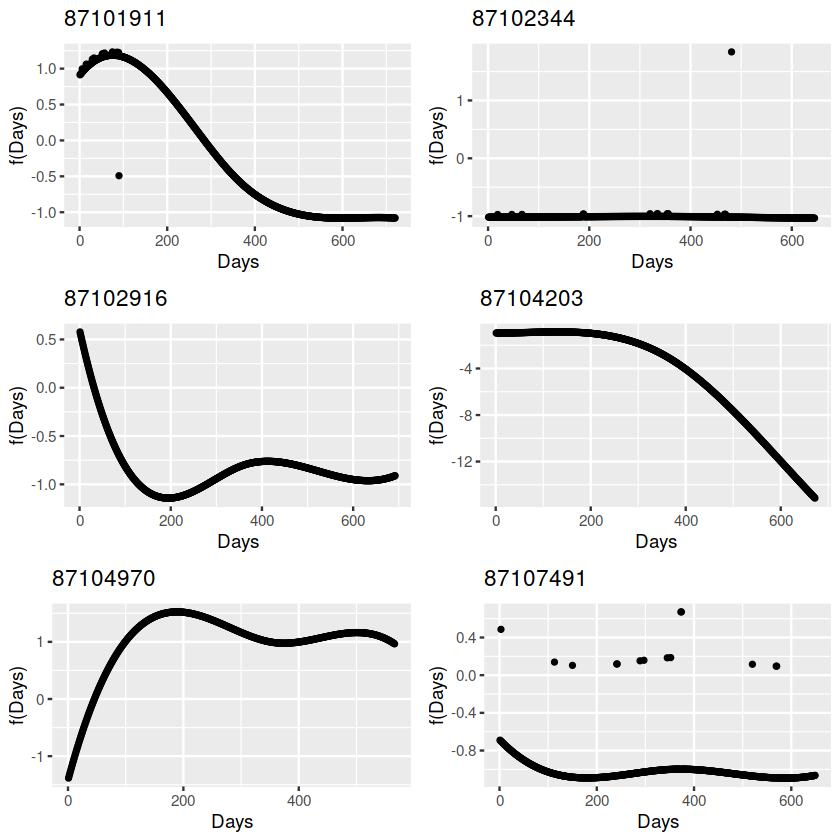

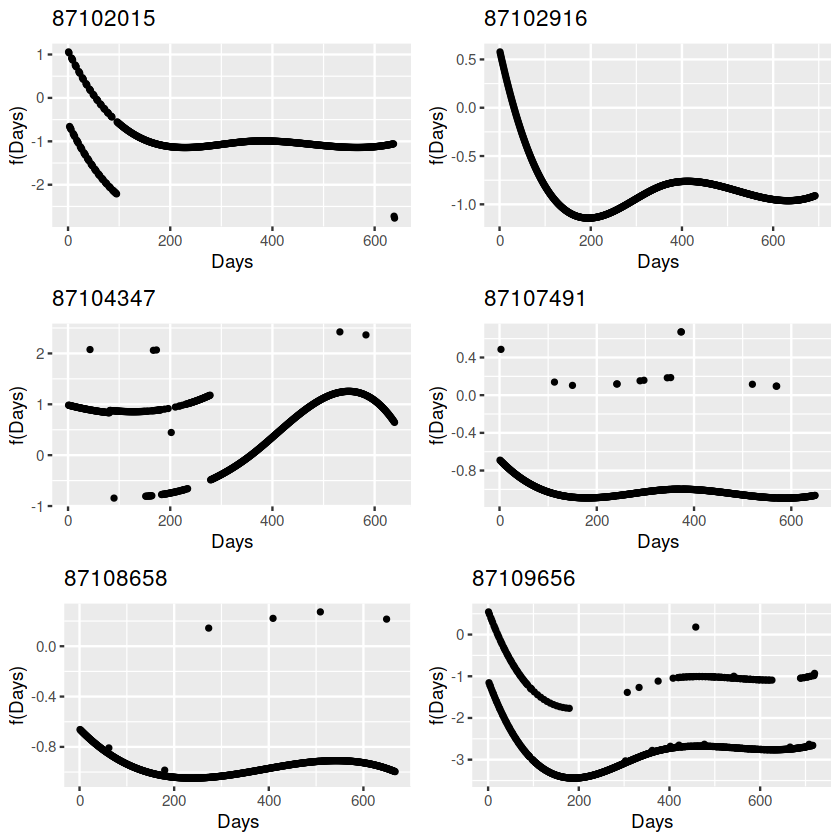

In [15]:
# prints 6 estimated trajectories per page
subjects<-unique(U)

vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

pages <- 3   # How many pages of output, 6 plots to a page
for (i in 1:pages) {
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(3, 2)))
    for (j in 1:6) {
        index <- i*j
        # function that summaries the results from the SVM.Mixed into a plot for an individual
        fig1 <- Ind.trajectory(subj=subjects[index], X, T, U, MCMC.res, burn.in, knot.seq, Tmax)
        if ((j %% 2) == 0) {
            print(fig1, vp = vplayout(j/2, 2))
        } else {
            print(fig1, vp = vplayout(ceiling(j/2), 1))
        }
   } 
}


The user may look closely at an individual's estimated risk of heavy drinking trajectory over time. The function Ind.trajectory.pretty takes in the subject indentifier and the results of SVM.Mixed and presents the estimated heavy drinking trajectories for four individuals in the ABQ DrinQ data (87198709, 87178393, 87195831, and 8718920). Each point is the value of the linear predictor for that given day. The further the values are away from zero, the more or less likely at individualis going to have a heavy drinking day. These values are color coded by the 8 combinations of the 3 time varying covariates (nicotine, cannabis (THC), and other drug use).

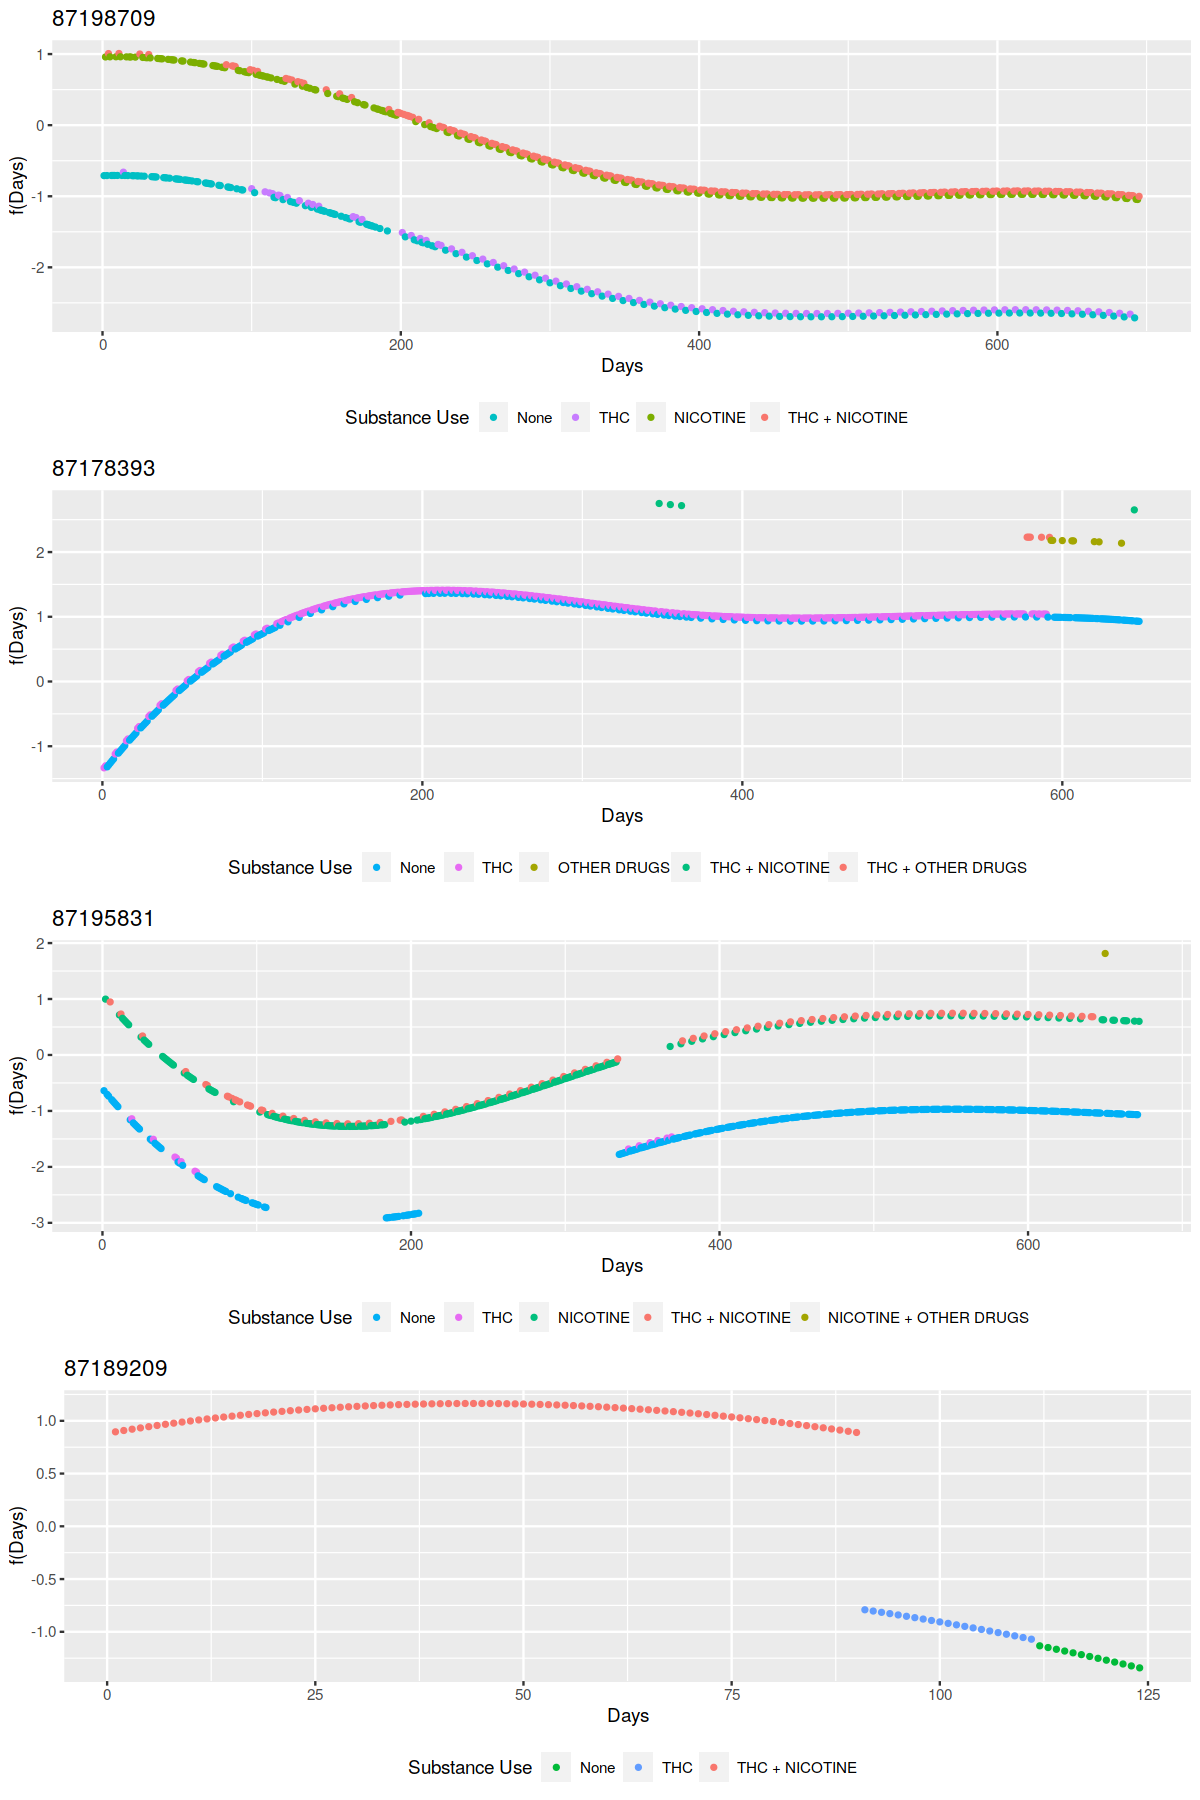

In [16]:
subjects<-unique(U)

subj <- c(87198709,87178393,87195831,87189209) # specify which subjects to plot

options(repr.plot.width=10, repr.plot.height=15)

vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

grid.newpage()
pushViewport(viewport(layout = grid.layout(length(subj), 1)))

for (j in 1:length(subj)) {
    fig1 <- Ind.trajectory.pretty(subj=subj[j], X, T, U, MCMC.res, burn.in, knot.seq, Tmax)
    print(fig1,vp=vplayout(j,1))
} 


* Patient 87198709 is alternating between cannabis use and smoking.  The risk  of  heavy  drinking  is  greatly  increased  when  the  subject smokes  tobacco  (upper  curve).  In  general,  this  patient  reduced  their  heavy drinking during the beginning of the study. 

* Patient 87178393 uses cannabis regularly and smokes tobacco or uses other drugs occasionally (dots of elevated risk). As seen, the risk of heavy drinking greatly increases when using other substances. 

* Patient 87195831 uses cannabis and smokes tobacco regularly. Initially the patient’s risk of heavy drinking decreased but then increased  again  after  day  200  in  the  study  with  more  regular  use  of tobacco. Near the end of followup, the patient started using other drugs, a red flag. 

* Patient 87189209 was a regular tobacco smoker and then stopped smoking around Day 90 (near their baseline assessment). Their risk of heavy drinking continued to decline, which is encouraging.